<a href="https://colab.research.google.com/github/Lousiboupi/Machine-learning-project/blob/main/Evolve_Equinor_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import curve_fit

# import du dataset excel et affichage des colonnes


all_data = pd.read_excel('Volve_production_data.xlsx', sheet_name = None)


daily_data = all_data["Daily Production Data"]
monthly_data = all_data["Monthly Production Data"]

#Ici on va forcer certains parametre pour éviter des decimales inutiles
daily_data[['NPD_WELL_BORE_CODE', 'NPD_FIELD_CODE', 'NPD_FACILITY_CODE']] = daily_data[["NPD_WELL_BORE_CODE", "NPD_FIELD_CODE", "NPD_FACILITY_CODE"]].astype('str')
monthly_data[['NPDCode', 'Year', 'Month']] = monthly_data[["NPDCode", "Year", "Month"]].astype('str')

daily_data = daily_data.round(2)
monthly_data = monthly_data.round(2)

print(daily_data.columns)


Index(['DATEPRD', 'WELL_BORE_CODE', 'NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME',
       'NPD_FIELD_CODE', 'NPD_FIELD_NAME', 'NPD_FACILITY_CODE',
       'NPD_FACILITY_NAME', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE',
       'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS',
       'AVG_CHOKE_SIZE_P', 'AVG_CHOKE_UOM', 'AVG_WHP_P', 'AVG_WHT_P',
       'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'BORE_WI_VOL', 'FLOW_KIND', 'WELL_TYPE'],
      dtype='object')


In [2]:
# paiplot for key data
cols = ["BORE_OIL_VOL", "BORE_GAS_VOL", "BORE_WAT_VOL", "AVG_DOWNHOLE_PRESSURE", "AVG_DOWNHOLE_TEMPERATURE"]
# sns.pairplot(daily_data[cols].dropna())
# plt.show()

In [3]:
# #pairplot for all data

# # Sélection uniquement des colonnes numériques
data_num = daily_data.select_dtypes(include="number")

# sns.pairplot(data_num, diag_kind="kde")
# plt.show()

In [4]:
# global statistics
stats = data_num.describe().T
stats["missing_%"] = data_num.isnull().mean() * 100

# print("Statistiques globales :")
# print(stats)

# data distribution
# data_num.hist(figsize=(16, 12), bins=30)
# plt.suptitle("Distributions des variables numériques", fontsize=16)
# plt.show()

In [5]:
#stability verification with random sampling
sample1 = data_num.sample(frac=0.3, random_state=1)
sample2 = data_num.sample(frac=0.3, random_state=2)

comparison = pd.DataFrame({
    "mean_full": data_num.mean(),
    "mean_sample1": sample1.mean(),
    "mean_sample2": sample2.mean()
})

print("mean compare (dataset vs sampling) :")
print(comparison)

mean compare (dataset vs sampling) :
                              mean_full   mean_sample1   mean_sample2
ON_STREAM_HRS                 19.994095      19.965257      20.055312
AVG_DOWNHOLE_PRESSURE        181.803906     181.678133     184.254044
AVG_DOWNHOLE_TEMPERATURE      77.162982      77.372696      78.015615
AVG_DP_TUBING                154.028820     153.064574     156.068471
AVG_ANNULUS_PRESS             14.856086      15.012633      15.005163
AVG_CHOKE_SIZE_P              55.168560      54.220770      54.515265
AVG_WHP_P                     45.377821      46.243637      45.071719
AVG_WHT_P                     67.728389      67.454827      67.464760
DP_CHOKE_SIZE                 11.441017      11.717581      11.275190
BORE_OIL_VOL                1095.631548    1097.080904    1105.262015
BORE_GAS_VOL              161049.059703  161270.249500  162488.296319
BORE_WAT_VOL                1672.151332    1647.605653    1656.146520
BORE_WI_VOL                 5315.480815    5375.47220

In [6]:
#outliers detection and description
outliers_summary = {}

for col in data_num.columns:
    Q1 = data_num[col].quantile(0.25)
    Q3 = data_num[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = data_num[(data_num[col] < lower) | (data_num[col] > upper)]

    outliers_summary[col] = {
        "n_outliers": len(outliers),
        "percent_outliers": round(len(outliers) / len(data_num) * 100, 2)
    }

outliers_data = pd.DataFrame(outliers_summary).T
print("Summary of outliers for each variable :")
print(outliers_data)

Summary of outliers for each variable :
                          n_outliers  percent_outliers
ON_STREAM_HRS                 3821.0             24.44
AVG_DOWNHOLE_PRESSURE            0.0              0.00
AVG_DOWNHOLE_TEMPERATURE         0.0              0.00
AVG_DP_TUBING                    0.0              0.00
AVG_ANNULUS_PRESS                0.0              0.00
AVG_CHOKE_SIZE_P                 0.0              0.00
AVG_WHP_P                      452.0              2.89
AVG_WHT_P                      554.0              3.54
DP_CHOKE_SIZE                 1742.0             11.14
BORE_OIL_VOL                   986.0              6.31
BORE_GAS_VOL                   916.0              5.86
BORE_WAT_VOL                     0.0              0.00
BORE_WI_VOL                    380.0              2.43


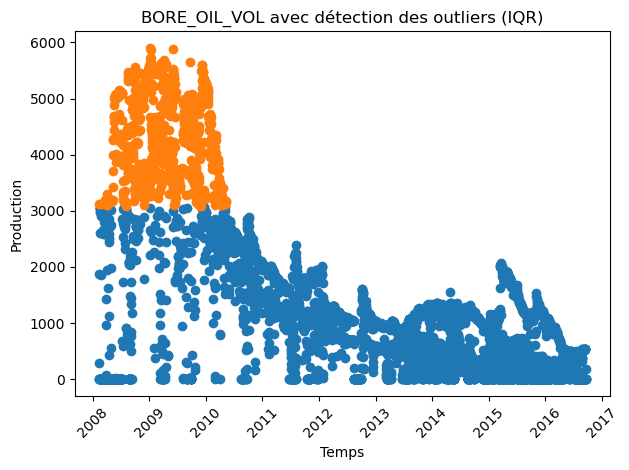

In [7]:
# -------------
# Affichage de la production d'huile avec les outliers détectés (STATISTIC APPORACH = NOT CONSERVED)
#--------------
date_col = "DATEPRD"        
prod_col = "BORE_OIL_VOL"    # Colonne de production choisie

daily_data[date_col] = pd.to_datetime(daily_data[date_col])
df = daily_data.sort_values(by=date_col)

# Garder uniquement les colonnes utiles
data = df[[date_col, prod_col]].dropna()

#Détection des outliers 
Q1 = data[prod_col].quantile(0.25)
Q3 = data[prod_col].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Masque des outliers 
outliers_mask = (data[prod_col] < lower) | (data[prod_col] > upper)

# Graphique
plt.figure()

# Points normaux en noir
plt.scatter(data.loc[~outliers_mask, date_col],
            data.loc[~outliers_mask, prod_col])

# Outliers en rouge
plt.scatter(data.loc[outliers_mask, date_col],
            data.loc[outliers_mask, prod_col])

plt.xlabel("Temps")
plt.ylabel("Production")
plt.title(f"{prod_col} avec détection des outliers (IQR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

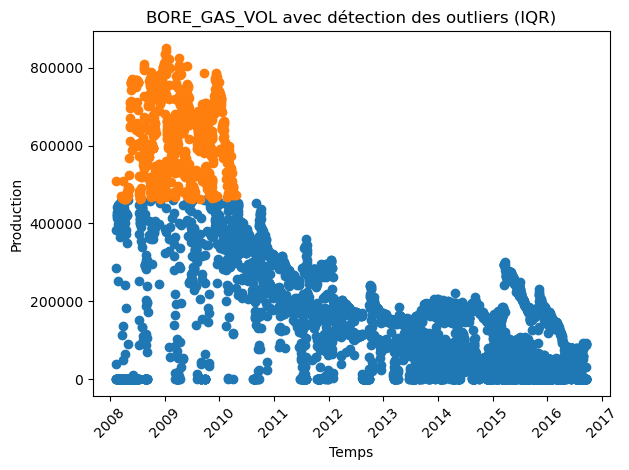

In [8]:
# -------------
# Affichage de la production de gaz avec les outliers détectés (STATISTIC APPORACH = NOT CONSERVED)
#--------------
date_col = "DATEPRD"        
prod_col = "BORE_GAS_VOL"    # Colonne de production choisie

daily_data[date_col] = pd.to_datetime(daily_data[date_col])
df = daily_data.sort_values(by=date_col)

# Garder uniquement les colonnes utiles
data = df[[date_col, prod_col]].dropna()

#Détection des outliers 
Q1 = data[prod_col].quantile(0.25)
Q3 = data[prod_col].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Masque des outliers 
outliers_mask = (data[prod_col] < lower) | (data[prod_col] > upper)

# Graphique
plt.figure()

# Points normaux en noir
plt.scatter(data.loc[~outliers_mask, date_col],
            data.loc[~outliers_mask, prod_col])

# Outliers en rouge
plt.scatter(data.loc[outliers_mask, date_col],
            data.loc[outliers_mask, prod_col])

plt.xlabel("Temps")
plt.ylabel("Production")
plt.title(f"{prod_col} avec détection des outliers (IQR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

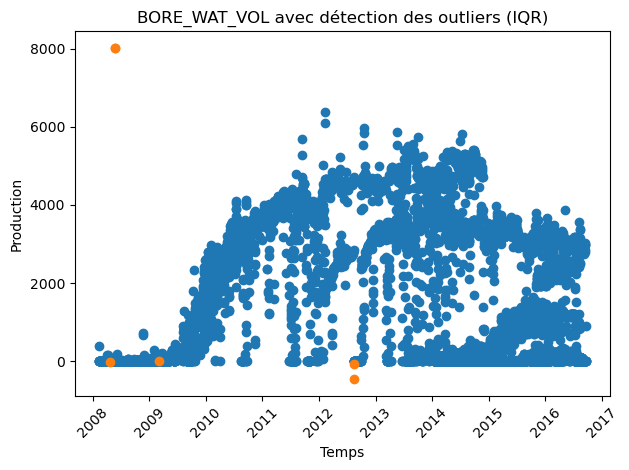

In [9]:
# -------------
# Affichage de la production d'eau avec les outliers détectés (STATISTIC APPORACH = NOT CONSERVED)
#--------------
date_col = "DATEPRD"        
prod_col = "BORE_WAT_VOL"    # Colonne de production choisie

daily_data[date_col] = pd.to_datetime(daily_data[date_col])
df = daily_data.sort_values(by=date_col)

# Garder uniquement les colonnes utiles
data = df[[date_col, prod_col]].dropna()

# Masque des outliers 
outliers_mask = (data[prod_col] < 0) | (data[prod_col] > 8000)

# Graphique
plt.figure()

# Points normaux en noir
plt.scatter(data.loc[~outliers_mask, date_col],
            data.loc[~outliers_mask, prod_col])

# Outliers en rouge
plt.scatter(data.loc[outliers_mask, date_col],
            data.loc[outliers_mask, prod_col])

plt.xlabel("Temps")
plt.ylabel("Production")
plt.title(f"{prod_col} avec détection des outliers (IQR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

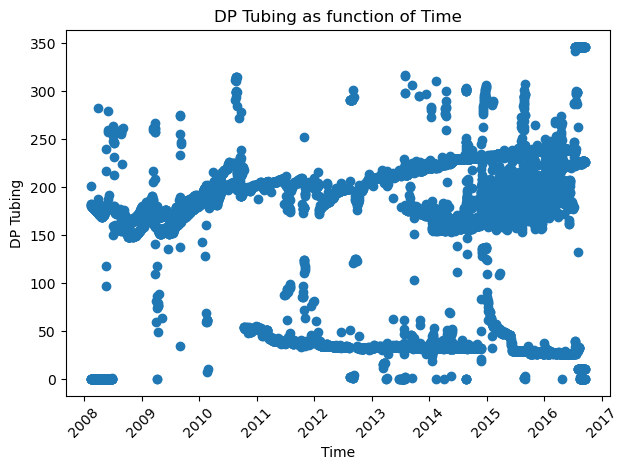

In [10]:
date_col = "DATEPRD"
tubing_col = "AVG_DP_TUBING"

daily_data[date_col] = pd.to_datetime(daily_data[date_col])
df = daily_data.sort_values(by=date_col)

data = df[[date_col, tubing_col]].dropna()

# Graphique
plt.figure()

plt.scatter(data[date_col], data[tubing_col])

plt.xlabel("Time")
plt.ylabel("DP Tubing")
plt.title("DP Tubing as function of Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

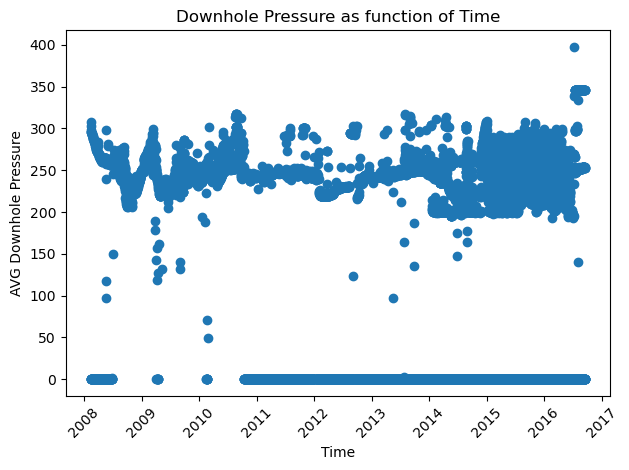

In [11]:
date_col = "DATEPRD"
tubing_col = "AVG_DOWNHOLE_PRESSURE"

daily_data[date_col] = pd.to_datetime(daily_data[date_col])
df = daily_data.sort_values(by=date_col)

data = df[[date_col, tubing_col]].dropna()

# Graphique
plt.figure()

plt.scatter(data[date_col], data[tubing_col])

plt.xlabel("Time")
plt.ylabel("AVG Downhole Pressure")
plt.title("Downhole Pressure as function of Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Axes: >

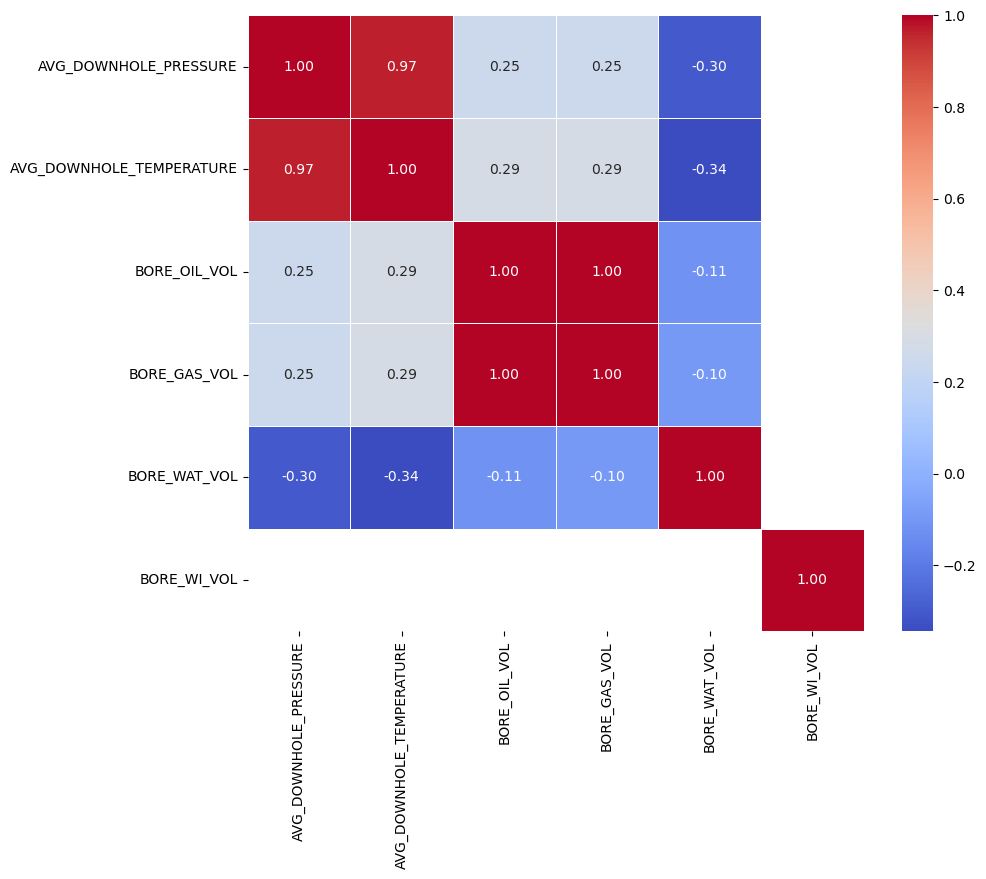

In [12]:
#correlation matrix key data
correlation_matrix_all = daily_data[['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 
                               'BORE_WAT_VOL', 'BORE_WI_VOL']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix_all,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)

# plt.title("Correlation Matrix")
# plt.show()

<Axes: >

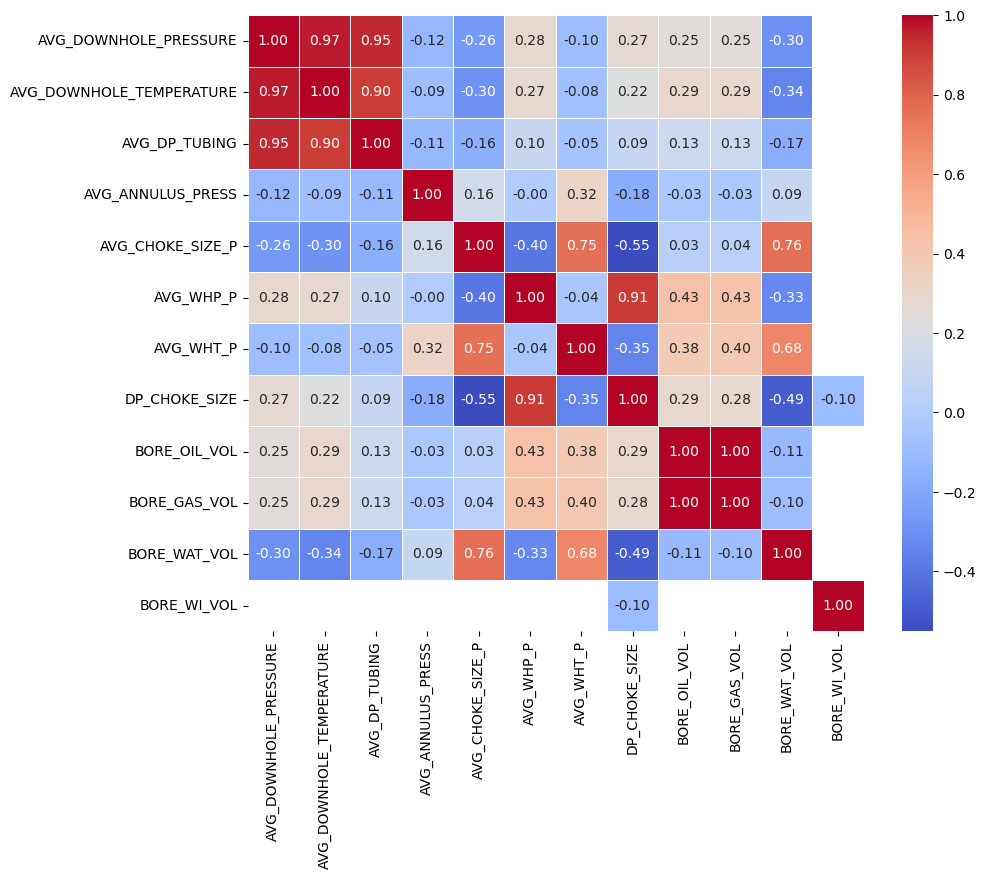

In [13]:
correlation_matrix_all = daily_data[['AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 
                               'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 
                               'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL', 'BORE_WI_VOL']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix_all,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)

# plt.title("Correlation Matrix")
# plt.show()

In [14]:
#Here I only select the well we are interested in 
well_data = daily_data[daily_data['NPD_WELL_BORE_NAME'] == '15/9-F-1 C']

#Creation of an excel with the new dataset well_data
well_data.to_csv('F-1C_data.csv', index=False)

In [15]:
# What is important for us would be to clean the data. However only the critical variables first, for examples BORE_OIL_VOL, BORE_GAS_VOL,
# AVG_DOWNHOLE_PRESSURE and AVG_DOWNHOLE_TEMPERATURE. 
# I want to try to create a set of data only for working days, so I will remove all the days where there is no production at all.
working_days_data = well_data[(well_data['BORE_OIL_VOL'] > 0) & (well_data['BORE_GAS_VOL'] > 0)]

working_days_data.to_csv('F-1C_working_days_data.csv', index=False)



/var/folders/1h/44kb91x93pb0vv00smjqmhmc0000gn/T/ipykernel_16081/937114269.py:22: RuntimeWarning: invalid value encountered in power
  return qi / ((1 + b * Di * t) ** (1/b))


Paramètres estimés :
qi = 521492.99
Di = 0.000516
b  = -0.5077


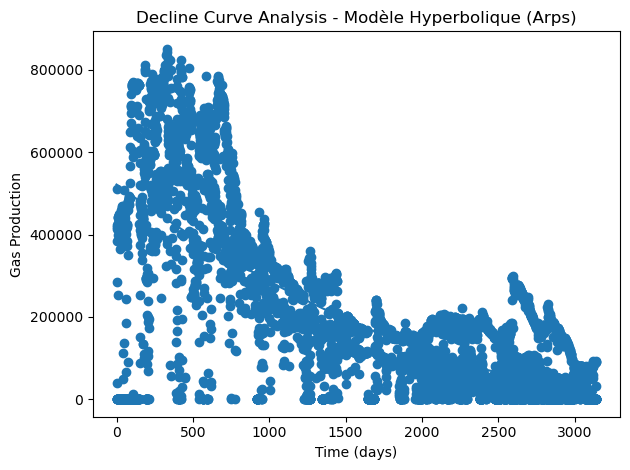

In [16]:
#------------
# Decline Curve analysis with Arps hyperbolic model    GAS PRODUCTION    
#------------

prod_col = "BORE_GAS_VOL"

daily_data[date_col] = pd.to_datetime(daily_data[date_col])
df = daily_data.sort_values(by=date_col)

data = df[[date_col, prod_col]].dropna()


# Création de la variable temps
data["t_days"] = (data[date_col] - data[date_col].min()).dt.days

t = data["t_days"].values
q = data[prod_col].values


# Modèle hyperbolique d’Arps
def arps_hyperbolic(t, qi, Di, b): # qi = production initiale, Di = taux de déclin initial, b = facteur de déclin
    return qi / ((1 + b * Di * t) ** (1/b))

# Estimation initiale des paramètres
initial_guess = [q[0], 0.001, 0.5]

params, _ = curve_fit(arps_hyperbolic, t, q, p0=initial_guess, maxfev=10000)

qi, Di, b = params

print("Paramètres estimés :")
print(f"qi = {qi:.2f}")
print(f"Di = {Di:.6f}")
print(f"b  = {b:.4f}")

# Courbe ajustée
t_fit = np.linspace(min(t), max(t), 500)
q_fit = arps_hyperbolic(t_fit, qi, Di, b)


# Graphique
plt.figure()

plt.scatter(t, q)
plt.plot(t_fit, q_fit)

plt.xlabel("Time (days)")
plt.ylabel("Gas Production")
plt.title("Decline Curve Analysis - Modèle Hyperbolique (Arps)")
plt.tight_layout()
plt.show()

In [17]:
#Lets start to do a linear regression

#These are the variables we want to use for the regression, the Bore_vol is the X and DHP is 
#the variable we want to predict (Y)
Bore_vol = working_days_data['BORE_OIL_VOL'] 
DHP = working_days_data[['AVG_DOWNHOLE_PRESSURE']]

Bore_vol_test, Bore_vol_train, DHP_test, DHP_train = train_test_split(Bore_vol, DHP, test_size = 0.2 
                                                                      , randome_state = 42)



TypeError: got an unexpected keyword argument 'randome_state'

15       143.219931
16       142.071215
17       143.054510
18       142.599119
19       143.115658
            ...    
15606    156.019821
15607    156.173742
15608    155.581144
15609    157.210232
15610    159.584301
Name: GOR, Length: 8008, dtype: float64


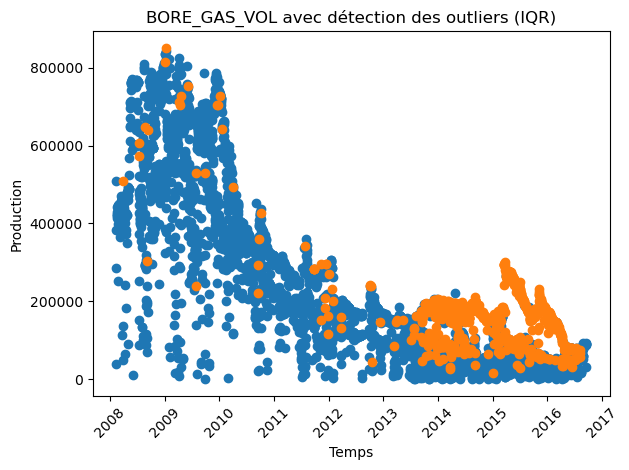

In [ ]:
#---------
#GAS OUTLIERS DEFINITION : GOR negative or brutal pic without drop corresponding to oil
#---------

#Calcul du GOR pour future définition des outliers
oil_col = "BORE_OIL_VOL"
gas_col = "BORE_GAS_VOL"
date_col = "DATEPRD"

# Supprimer valeurs nulles ou zéro huile (évite division par zéro)
data = daily_data[[date_col, oil_col, gas_col]].dropna()
data = data[data[oil_col] > 0]

# Calcul du GOR
data["GOR"] = data[gas_col] / data[oil_col]
print(data["GOR"])

# Date ordering in order to identify pics or drops
data[date_col] = pd.to_datetime(data[date_col])
data = data.sort_values(date_col).reset_index(drop=True)
# Condition1 : GOR negative
cond_gor_negative = data["GOR"] < 0
# Condition 2 : Brutal pic without drop corresponding to oil (ex: GOR > 1000)
data["OIL_PCT_CHANGE"] = data[oil_col].pct_change() # relative variation of oil production
SPIKE_THRESHOLD = 0.5    # +50% = pic brutal
DROP_THRESHOLD = -0.5    # -50% = chute brutale
spike_today = data["OIL_PCT_CHANGE"] > SPIKE_THRESHOLD # today's pic
drop_next = data["OIL_PCT_CHANGE"].shift(-1) < DROP_THRESHOLD # drop on the next day
cond_spike_drop = spike_today & drop_next

# outliers definition
outliers_gas = cond_gor_negative | cond_spike_drop

# Graphique
plt.figure()
# Points normaux en noir
plt.scatter(data.loc[~outliers_gas, date_col],data.loc[~outliers_gas, gas_col])
# Outliers en rouge
plt.scatter(data.loc[outliers_gas, date_col],data.loc[outliers_gas, gas_col])
plt.xlabel("Temps")
plt.ylabel("Production")
plt.title(f"{gas_col}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

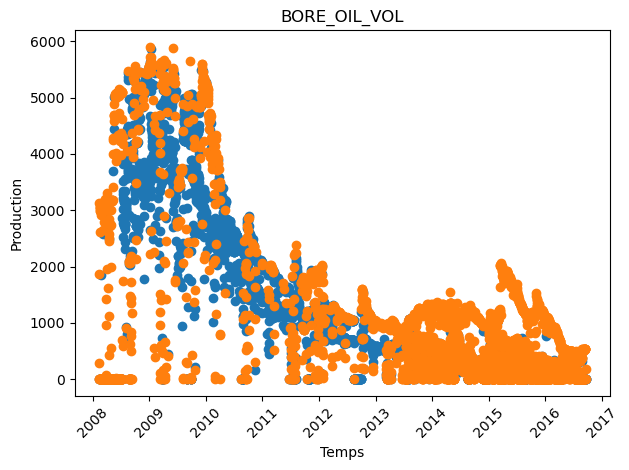

In [37]:
#---------
#OIL OUTLIERS DEFINITION : variation supérieure to 20-30% in 1 day or isolated pic then immediate return to normal 
#---------

# colomns used
oil_col = "BORE_OIL_VOL"
date_col = "DATEPRD"

# cleaning of the data
data = daily_data[[date_col, oil_col]].dropna()

# date ordering
data[date_col] = pd.to_datetime(data[date_col])
data = data.sort_values(date_col).reset_index(drop=True)

# CONDITION 1 : Variation > 20-30% in one day
data["OIL_PCT_CHANGE"] = data[oil_col].pct_change()
var_thresholdT = 0.5   # 50%   ?????
cond_variation = abs(data["OIL_PCT_CHANGE"]) > var_thresholdT
# CONDITION 2 : isolated pic + immediate return

# definition of normality
data["normal"] = data[oil_col].rolling(10, center=True).median() #--> ajustement de la valeur du  rolling également

# pic if > 35% above the "normal" 
spike_local = 0.7 #--> adjusted because the first values were to agressive
local_pic = data[oil_col] > data["normal"] * (1 + spike_local)

# return to normal if the next day is back to normal range 
return_normal = 0.5 #--> adjusted because the first values were to agressive
return_next = abs(data[oil_col].shift(-1) - data["normal"]) < data["normal"] * return_normal
cond_isolated_spike = local_pic & return_next

# oulier definition for oil
outliers_oil = cond_variation | cond_isolated_spike

# Graphique
plt.figure()
# Points normaux en noir
plt.scatter(data.loc[~outliers_oil, date_col],data.loc[~outliers_oil, oil_col])
# Outliers en rouge
plt.scatter(data.loc[outliers_oil, date_col], data.loc[outliers_oil, oil_col])
plt.xlabel("Temps")
plt.ylabel("Production")
plt.title(f"{oil_col}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

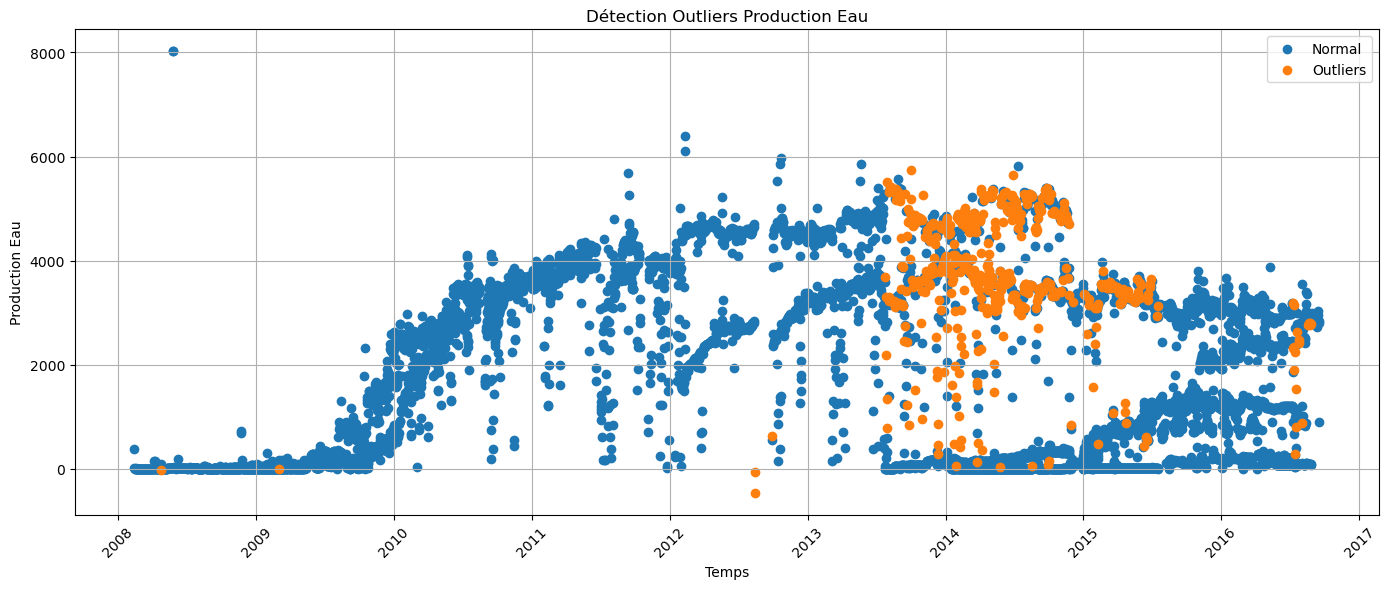

In [ ]:
#---------
#WATER OUTLIERS DEFINITION : - Passe de 10 à 80% en 1 jour sans explication , Supérieure à 100% (erreur de mesure), Négatifiate return to normal 
#---------

#columns defintion
oil_col = "BORE_OIL_VOL"
water_col = "BORE_WAT_VOL"
date_col = "DATEPRD"

data = daily_data[[date_col, oil_col, water_col]].dropna()
data = data[(data[oil_col] + data[water_col]) > 0] # Eviter division par zéro

# Calcul Water Cut
data["WATER_CUT"] = data[water_col] / (data[oil_col] + data[water_col])

# date ordering in order to identify pics or drops
data[date_col] = pd.to_datetime(data[date_col])
data = data.sort_values(date_col).reset_index(drop=True)

# CONDITION 1 : Passe de 10% → 80% en 1 jour
data["WC_DIFF"] = data["WATER_CUT"].diff()
# seuil variation brutale WC
WC_SPIKE_THRESHOLD = 0.5   # 50% jump

cond_wc_spike = ((data["WATER_CUT"].shift(1) < 0.2) &   # avant faible eau
                 (data["WATER_CUT"] > 0.7))               # après forte eau

# CONDITION 2 : Water cut > 100%
cond_wc_over_100 = data["WATER_CUT"] > 1

# CONDITION 3 :Eau négative
cond_water_negative = data[water_col] < 0

#outliers defintion
outliers_water = (cond_wc_spike | cond_wc_over_100 | cond_water_negative)

# graphique
plt.figure(figsize=(14,6))
# Normal
plt.scatter(data.loc[~outliers_water, date_col],data.loc[~outliers_water, water_col],label="Normal")
# Outliers
plt.scatter(data.loc[outliers_water, date_col],data.loc[outliers_water, water_col],label="Outliers")
plt.xlabel("Time")
plt.ylabel("Water production")
plt.title("outliers detection for water production")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()